In [137]:
import cv2
import subprocess
import potrace
import time
import numpy as np
from pt import get_pt
import argparse
from matplotlib import pyplot as plt
from l0smooth.L0_serial import l0_smooth
from IPython.display import Image, display, SVG

# Preprocessing

In [138]:
%matplotlib inline
IMAGE_PATH = "./images/img7.png"
start_time = time.time()
image_l0 = l0_smooth(IMAGE_PATH)

image_gray = cv2.cvtColor(image_l0, cv2.COLOR_BGR2GRAY)

image_blur = cv2.GaussianBlur(image_gray, (5, 5), 0)

high_thresh_blur, thresh_im = cv2.threshold(image_blur.astype('uint8'), 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

low_thresh_blur = 0.5 * high_thresh_blur

image_can = cv2.Canny(image_blur.astype('uint8'), low_thresh_blur, high_thresh_blur, True)

#image_can = cv2.Canny(image_blur.astype('uint8'), low_thresh_blur, high_thresh_blur, True, apertureSize=5)

img_can_invrt = np.invert(image_can)

Processing 401 x 221 RGB image


[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


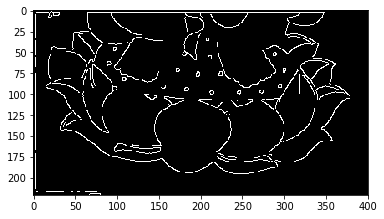

In [139]:
plt.imshow(image_can, cmap='Greys_r')
print(image_can)

# Outer Edge Detection

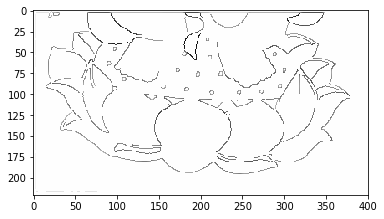

In [140]:
image_outer = np.zeros(image_blur.shape)

for i in range(0, len(image_outer)):
    for j in range(0, len(image_outer[i])):
        if(image_can[i][j] == 255):
            image_outer[i][j] = image_blur[i][j]
        else:
            image_outer[i][j] = 255
            
invert_canny_img = np.zeros(image_blur.shape)

for i in range(0, len(invert_canny_img)):
    for j in range(0, len(invert_canny_img[i])):
        if(image_can[i][j] == 255):
            invert_canny_img[i][j] = 0
        else:
            invert_canny_img[i][j] = 255
            
plt.imshow(image_outer, cmap='Greys_r')

# Inner Edge Detection + Thresholding

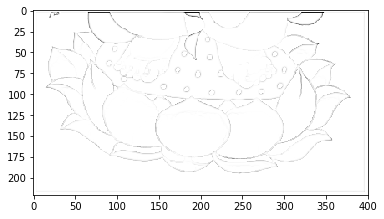

In [141]:
image_inner = np.zeros(image_blur.shape)

for i in range(0, len(image_inner)):
    for j in range(0, len(image_inner[i])):
        if(image_blur[i][j] == 0):
            delta = 255.0
        else:
            delta = ((255.0 - image_blur[i][j]) / float(image_blur[i][j])) * image_gray[i][j]

        image_inner[i][j] = min(255.0, (image_gray[i][j] + delta))

plt.imshow(image_inner, cmap='Greys_r')

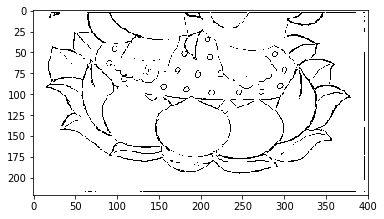

In [142]:
high_thresh_inner, thresh_im_inner = cv2.threshold(image_inner.astype('uint8'), 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

image_inner_thresh = np.zeros(image_blur.shape)

for i in range(0, len(image_inner_thresh)):
    for j in range(0, len(image_inner_thresh[i])):
        if(image_inner[i][j] >= high_thresh_inner):
            image_inner_thresh[i][j] = 255
        else:
            image_inner_thresh[i][j] = 0

plt.imshow(image_inner_thresh, cmap='Greys_r')

# Stroke Integration

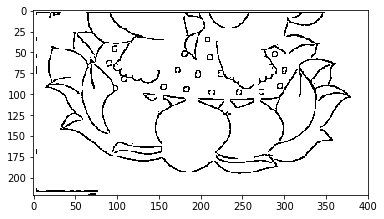

In [143]:
image_int = np.zeros(image_blur.shape)
max_i, max_j = image_blur.shape

for i in range(0, len(image_int)):
    for j in range(0, len(image_int[i])):
        if(image_inner[i][j] != 255):
            if(i == 0):
                if(j == 0):
                    if(img_can_invrt[i][j+1] == 0 or img_can_invrt[i+1][j] == 0 
                               or img_can_invrt[i+1][j+1] == 0):

                        image_int[i][j] = 0
                    else:
                        image_int[i][j] = 255
                elif(j == max_j-1):
                    if(img_can_invrt[i][j-1] == 0 or img_can_invrt[i+1][j] == 0 
                               or img_can_invrt[i+1][j-1] == 0):
                        image_int[i][j] = 0
                    else:
                        image_int[i][j] = 255
                else:
                    if(img_can_invrt[i][j-1] == 0 or img_can_invrt[i+1][j] == 0 
                       or img_can_invrt[i+1][j-1] == 0 or img_can_invrt[i][j+1] == 0
                               or img_can_invrt[i+1][j+1] == 0):
                        image_int[i][j] = 0
                    else:
                        image_int[i][j] = 255
  
            elif(i == max_i-1):
                if(j == 0):
                    if(img_can_invrt[i][j+1] == 0 or img_can_invrt[i-1][j] == 0 
                               or img_can_invrt[i-1][j+1] == 0):
                        image_int[i][j] = 0
                    else:
                        image_int[i][j] = 255
                elif(j == max_j-1):
                    if(img_can_invrt[i][j-1] == 0 or img_can_invrt[i-1][j] == 0
                               or img_can_invrt[i-1][j-1] == 0):
                        image_int[i][j] = 0
                    else:
                        image_int[i][j] = 255
                else:
                    if(img_can_invrt[i][j-1] == 0 or img_can_invrt[i-1][j] == 0
                       or img_can_invrt[i-1][j-1] == 0 or img_can_invrt[i][j+1] == 0 
                               or img_can_invrt[i-1][j+1] == 0):
                        image_int[i][j] = 0
                    else:
                        image_int[i][j] = 255
            else:
                if(j == 0):
                    if(img_can_invrt[i-1][j] == 0 or img_can_invrt[i-1][j+1] == 0
                       or img_can_invrt[i][j+1] == 0 or img_can_invrt[i+1][j+1] == 0
                               or img_can_invrt[i+1][j] == 0):
                        image_int[i][j] = 0
                    else:
                        image_int[i][j] = 255
                elif(j == max_j-1):
                    if(img_can_invrt[i-1][j] == 0 or img_can_invrt[i-1][j-1] == 0 
                       or img_can_invrt[i][j-1] == 0 or img_can_invrt[i+1][j-1] == 0
                               or img_can_invrt[i+1][j] == 0):
                        image_int[i][j] = 0
                    else:
                        image_int[i][j] = 255
                    
                else:
                    if(img_can_invrt[i-1][j] == 0 or img_can_invrt[i-1][j-1] == 0 
                       or img_can_invrt[i][j-1] == 0 or img_can_invrt[i+1][j-1] == 0
                       or img_can_invrt[i+1][j] == 0 or img_can_invrt[i-1][j+1] == 0 
                       or img_can_invrt[i][j+1] == 0 or img_can_invrt[i+1][j+1] == 0):
                        image_int[i][j] = 0
                    else:
                        image_int[i][j] = 255
        else:
            image_int[i][j] = 255

plt.imshow(image_int, cmap='Greys_r')

True

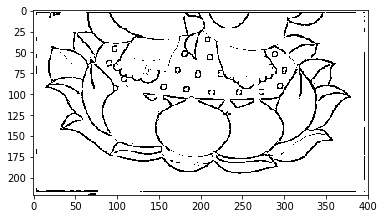

In [144]:
image_for_opt = np.zeros(image_blur.shape)

for i in range(0, len(image_for_opt)):
    for j in range(0, len(image_for_opt[i])):
        if(image_inner_thresh[i][j] == 255 and image_int[i][j] == 255):
            image_for_opt[i][j] = 255
        else:
            image_for_opt[i][j] = 0

plt.imshow(image_for_opt, cmap='Greys_r')
cv2.imwrite('imforopt.png', image_for_opt)

# Stroke Optimisation

Time taken: 12.756 seconds


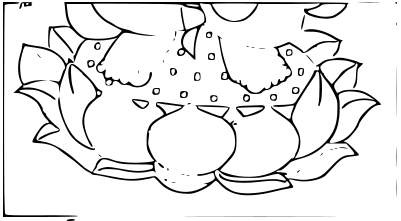

In [145]:
get_pt()
elapsed_time = time.time() - start_time
print('Time taken: %.3f seconds' % elapsed_time)
display(SVG(filename='imforopt.svg'))